<a id="inicio"></a>
<img src="http://www.cidaen.es/assets/img/cidaenNB.png" alt="Logo CiDAEN" align="right">




<br><br><br>
<h2><font color="#004D7F" size=4>Proyecto II: Machine learning</font></h2>



<h1><font color="#004D7F" size=5>Predicción de abandono en una empresa de telecomunicaciones.</font></h1>


<br><br><br><br><br><br>

<div style="text-align: right">
<font color="#004D7F" size=3>Luis de la Ossa, Cristina Romero</font><br>
<font color="#004D7F" size=3>Curso de Especialista en Ciencia de Datos y Desarrollo de Aplicaciones en la Nube </font><br>
<font color="#004D7F" size=3>Universidad de Castilla-La Mancha</font>

</div>

<br>

---


<br>

<h2><font color="#004D7F" size=5>Introducción</font></h2>
<br>

En este proyecto se pondrán en práctica algunos de los conceptos tratados en el módulo cuatro del curso. A diferencia del primer proyecto, cuyo objetivo principal era el dominio de las herramientas mediante la resolución de una serie de ejercicios guiados, éste se centrará en la __aplicación y estudio de una metodología correcta__.  Para ello se propone un flujo de trabajo, pero también se plantean algunas preguntas que han de ser respondidas en la propia libreta. 


Además se propone que, con carácter __totalmente opcional__, se reproduzca el proceso sobre un conjunto de datos distinto al que se usará en el proyecto. 

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i> Este proyecto es abierto, por lo que se permite que os tomeis libertad de cambiar cualquier paso, siempre y cuando el procedimiento sea correcto, y que el objetivo y resultados sean los que se persiguen.
</div>

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns;
sns.set()

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# Random Seed
random_seed = 42

<div class="alert alert-block alert-danger">
    
<i class="fa fa-exclamation-triangle" aria-hidden="true"></i>
Es necesario utilizar la versión `0.20` o posterior de `scikit-learn`.
</div>

---

<a id="indice"></a>
<h2><font color="#004D7F" size=5>Índice</font></h2>


* [1. Prevención del abandono (_churn prevention_)](#section1)
* [2. Planteamiento](#section2)
* [3. Exploración de los datos. Preprocesamiento](#section3)
    * [3.1. Variables numéricas](#section31)
    * [3.2. Variables categóricas](#section32)    
    * [3.3. Preprocesamiento](#section33)  
* [4. Construcción de un modelo](#section4)    
    * [4.1 Creación del Pipeline y construcción de un modelo inicial](#section41)   
    * [4.2 Selección y ajuste del modelo](#section42) 
    * [4.3 Calibración del modelo](#section43)   
* [5. Validación sobre nuevos datos](#section5)     

<a id="section1"></a>
## <font color="#004D7F"> 1. Prevención del abandono </font>

<br> La prevención del abandono, o _Churn prevention_, es una tarea de _márketing_ que consiste en detectar 
aquellos clientes que presentan cierto riesgo de abandonar un determinado servicio o mercado, y llevar a cabo campañas espefíficas de retención con el fin de evitar la pérdida. 
<br>

Este proyecto consiste en la elaboración de un modelo basado en aprendizaje supervisado para la detección de clientes en esta situación. Se proporciona un conjunto de datos, denominado, `customerChurnAnalysis.csv`, relativo al abandono en una operadora de telecomunicaciones. Alguna información adicional, así como _kernels_ que tratan estos mismos datos y pueden resultar útiles (_se recomienda que los miréis_) están disponibles en [Kaggle](https://www.kaggle.com/becksddf/churn-in-telecoms-dataset). 

In [2]:
# Se cargan los datos 
df_churn = pd.read_csv('data/churn/customerChurnAnalysis.csv');

print("Tamaño del conjunto de datos:  %d" % df_churn.shape[0])
print("Número de variables: %d" % df_churn.shape[1])
# Visualiza las primeras instancias
df_churn.head()

Tamaño del conjunto de datos:  3333
Número de variables: 21


,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


Como línea de trabajo, se asumirá que el objetivo del modelo es su uso en un escenario real, es decir, para el tratamiento de datos que no disponibles durante el desarrollo. Debido a esto, se dividirá el conjunto de datos almacenado en `df_churn` en dos: `df_churn` con el 85% de los datos, y que será utilizado en el aprendizaje del modelo; y `df_churn_new`, con el 15% restante. 

<div class="alert alert-block alert-warning">
    
<i class="fa fa-exclamation-circle" aria-hidden="true"></i> El conjunto de datos `df_churn_new` __no será utilizado en ninguna fase del proceso de aprendizaje__, ni siquiera para la exploración, preprocesamiento, o la selección del modelo. 
</div>

In [3]:
# Tamaño del conjunto de entrenamiento
training_size = int(len(df_churn)*0.85)
# Desordena los datos (esto es muy importante).
df_churn = df_churn.sample(frac=1, random_state=0).reset_index(drop=True)
# Copia los datos de test.
df_churn_new = df_churn.iloc[training_size:].copy()
# Copia los datos para el entrenamiento del modelo.
df_churn = df_churn.iloc[:training_size].copy()

---
Para mejorar el holdout previo, podemos garantizar la misma proporción de casos en los conjuntos de entrenamiento y de validación. Para ello se hará uso de [**train_test_split**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) usando los argumentos *shuffle* y *stratify* para reordenar y repartir de manera balanceada los dos posibles casos de la variable clase *churn*.

Con el objetivo de seguir con el capstone original, estos bloques de códigos están comentados. Para realizar el capstone con estratificación, descomenta cada línea de código y vuelve a ejecutar.

In [4]:
from sklearn.model_selection import train_test_split
# Tamaño del conjunto de entrenamiento
training_size = int(len(df_churn)*0.85)
# Rebalancea los datos en el holdout
y = df_churn["churn"]
X = df_churn.drop("churn", axis=1)

X_train, X_test, y_train, y_test = train_test_split(
                                         X,
                                         y,
                                         train_size=training_size,
                                         random_state=random_seed,
                                         shuffle=True,
                                         stratify=y)

In [5]:
print("Proporción True / False del conjunto de entremaniento: ", y_train.value_counts()[1]/y_train.value_counts()[0])
print("Proporción True / False del conjunto de validación: ", y_test.value_counts()[1]/y_test.value_counts()[0])

Proporción True / False del conjunto de entremaniento:  0.1644100580270793
Proporción True / False del conjunto de validación:  0.1643835616438356


In [6]:
# Unimos el array de clase al dataframe tanto para el entrenamiento como para la validación
df_churn = X_train.copy()
df_churn["churn"] = y_train
df_churn_new = X_test.copy()
df_churn_new["churn"] = y_test


In [7]:
print("Tamaño del conjunto de datos disponibles: ", len(df_churn))
print("Tamaño del conjunto de nuevos datos: ", len(df_churn_new))

Tamaño del conjunto de datos disponibles:  2408
Tamaño del conjunto de nuevos datos:  425


<div class="alert alert-block alert-success" markdown=1>

__Comentarios__. _Correcto_. Lo voy a dejar así. No pasa nada si no coinciden los resultados.
```python

```
</div>

<div style="text-align: right">
<a href="#inicio"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></font></a>
</div>

---

<a id="section2"></a>
## <font color="#004D7F"> 2. Planteamiento </font>
<br>

En ciencia de datos es frecuente que el punto de partida del trabajo lo constituyan datos desconocidos. El primer paso, también cuando se trabaja con aprendizaje automático, consiste en explorar estos datos. Además de la familiarización con el problema (que no siempre es posible), como fruto de la exploración surgen decisiones que afectan _principalmente_ a la preparación y al preprocesamiento. 
<br>

En general, el proceso de exploración no es sistemático, sino que se lleva a cabo en base a los datos que el mismo va arrojando, y guiado en parte por la intuición y experiencia del analista. En cada paso, surge la necesidad de hacer transformaciones a los datos originales de cara a su uso en la construción del modelo. Estos cambios pueden ir haciéndose progresivamente. Sin embargo, todo el proceso ha de ser registrado de algún modo, ya que ha de ser reproducido para el tratamiento de nuevos datos que, en un contexto real, se supone que son adquiridos con el formato del conjunto de datos original.
<br>

A lo largo del módulo se ha estudiado como hacer _Pipelines_ o secuencias de funciones en `scikit-learn`. Aunque __esta funcionalidad es muy útil__, incorporar todo el proceso de los datos dentro de un _Pipeline_ puede ser tedioso, e incluso puede haber limitaciones que lo impidan o hagan recomendable un modo alternativo de trabajo. En realidad, es posible apartar (y anticipar) algunas _tareas de preparación datos_ del proceso definido en el _Pipeline_. Así, operaciones como la eliminación o transformación de columnas, cuya aplicación en nuevos datos es totalmente independiente del entrenamiento,  pueden llevarse a cabo mediante una función previa a la construcción del modelo (y repetirse previamente a su uso).
<br>

En este proyecto se propone un modo de trabajar en el que sucesivamente, _durante la exploración_, se aplicarán funciones de preprocesamiento a un _DataFrame_. Estas funciones serán almacenadas en una lista que, finalmente, podrá ser utilizada para la reproducción del preprocesamiento sobre nuevos datos. 
<br>

Una vez disponible una versión adecuada de los datos, el trabajo con `scikit-learn` se hará según el procedimiento habitual, que incluye tanto otra fase de preprocesamiento como la construcción/uso del modelo.


<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i> __Nota__: El modo de trabajo que se propone __no es el único, pero es una alternativa__ que puede ser conveniente en algunos supuestos, y distinta a las vistas en clase. 
</div>

<div style="text-align: right">
<a href="#inicio"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></font></a>
</div>

---

<a id="section3"></a>
## <font color="#004D7F"> 3. Exploración de los datos. Preprocesamiento. </font>
<br>

Como se comentó anteriormente, durante el proceso de exploración, o fruto del mismo, se somete a los datos a una serie de transformaciones. Éstas darán como resultado un nuevo conjunto de datos que, a su vez, es posible que sea sometido a alguna transformación adicional dentro del _Pipeline_ de `scikit-learn`. Considerando este planteamiento, se definirán tres listas que serán de utilidad durante el proceso:

* `churn_data_preprocessing`, que guardará la secuencia de funciones (referencias) aplicadas al _DataFrame_
* `cat_features`, que guardará los nombres de las columnas que han de ser tratadas posteriormente como categóricas. 
* `num_features`, que guardará los nombres de las columnas que han de ser tratadas posteriormente como numéricas. 

In [8]:
# Lista de funciones aplicadas en el preprocesamiento
churn_data_preprocessing = []

# Características que serán consideradas categóricas y numéricas en el pipeline
cat_features = []
num_features = []

El objetivo principal de este trabajo es predecir la baja de un determinado usuario mediante un modelo de clasificación. Por eso, uno de los pasos más importantes en la exploración consiste en el análisis e interpretación de la distribución de las clases. Éste factor puede resultar de interés en el entrenamiento, pero también de cara a la evaluación.

<font color="#004D7F" size=3> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#004D7F"></i></font> Dibujar un diagrama de barras (`sns.countplot`) con la distribución de las clases sobre las muestras. Obtener los posibles valores de las mismas. 

Clases:  [False  True]
El porcentaje de muestras positivas es 0.141196


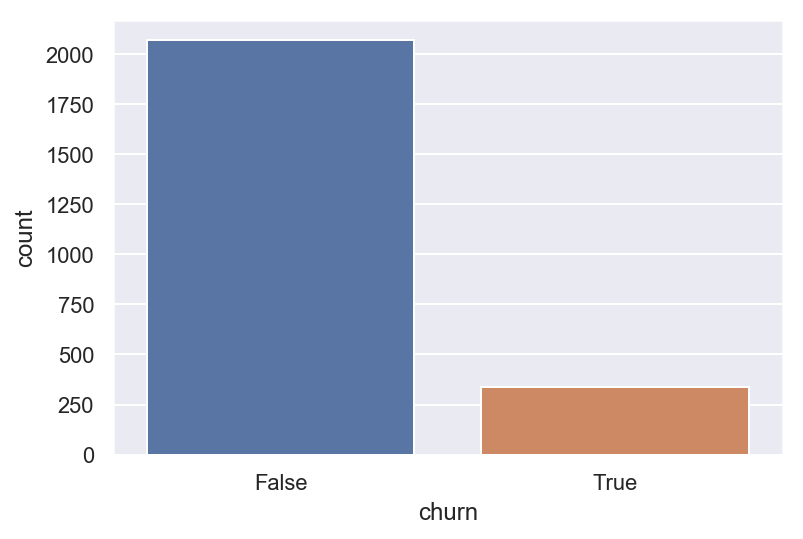

In [9]:
print("Clases: ", df_churn['churn'].unique())

#
# COMPLETAR
#
sns.countplot("churn", data=df_churn)

print("El porcentaje de muestras positivas es %f" % (sum(df_churn['churn']) / df_churn.shape[0]))

<div class="alert alert-block alert-success" markdown=1>

__Comentarios__. _Correcto_
```python

```
</div>

<font color="#004D7F" size=3> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#004D7F"></i></font>  Comentar qué se aprecia en la gráfica, en qué modo puede afectar esto al rendimiento del clasificador, y si esto influye en el modo en que se ha de llevar a cabo la evaluación. 

---
Podemos ver como el porcentaje de muestras positivas es de un 0.14% lo cual implica que lo bueno o malo que sea un clasificador dependerá en gran medida del porcentaje de muestras positivas que sea capaz de acertar. Para entender este concepto mejor, supongamos un clasificador 0R, el cual clasificaría como _False_ cualquier ejemplo del dataframe. La precisión asociado a este clasificador sería de un total de 0.86, y sin acertar ninguno de los casos positivos.

A la hora de entrenar un clasificador esta desproporción de valores de clase hay que tenerla siempre en cuenta. Si en el conjunto de entrenamiento no tenemos muestras positivas, el clasificador nunca podrá aprender a distinguir entre ambas clases. Por otro lado, si no tenemos suficientes instancias positivas en el conjunto de validación, tampoco podremos comprobar si el clasificador disntingue correctamente entre las dos clases. Por lo tanto hay que llegar a un punto medio. Para ello, se debe repartir de forma proporcionada las clases positivas entre los conjuntos de entrenamiento y de validación usando estratificación. 

Esta desproporción de casos influye en gran medida en el modo en el que se va a llevar a cabo la evaluación, ya que como hemos visto antes partimos de una precisión base de 0.86 con un 0R. En este caso, la puntuación **recall** va a tener mucha más relevancia, ya que tiene en cuenta la cantidad de casos positivos evaluados correctamente.

---

<div class="alert alert-block alert-success" markdown=1>

__Comentarios__. _PERFECTO_.
```python

```
</div>

<br>

<div style="text-align: left"><font size=4> <i class="fa fa-check-square-o" aria-hidden="true" style="color:#004D7F"></i></font></div>
<br>


Puede apreciarse que las clases están codificadas por los _Strings_ `True` y `False`. Por tanto, la primera operación de transformación consiste en convertir ambos valores a `1` y `0`, respectivamente.

<br>

<font color="#004D7F" size=3> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#004D7F"></i></font> Crear una función para convertir la clase a entero, denominada `churn_binarize_class`, que reciba como parámetro un _DataFrame_. 
<div class="alert alert-block alert-warning">
<br>

<i class="fa fa-exclamation-circle" aria-hidden="true"></i> 
La función _puede_ no devolver nada, ya que actúa sobre el _DataFrame_ pasado como parámetro. Por otra parte, se prueba sobre una copia para evitar manipulaciones redundantes del _DataFrame_ `df_churn` que produzcan resultados inesperados (una de las desventajas de trabajar con Jupyter).
</div>

In [10]:
def churn_binarize_class(df):
    # COMPLETAR
    df["churn"] = df["churn"].astype(int)
    return df

# Comprueba si la función está bien
display(churn_binarize_class(df_churn.head(10).copy()))

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
175,ND,136,510,375-8596,yes,no,0,256.8,90,43.66,...,104,19.56,143.6,82,6.46,9.1,10,2.46,3,0
1330,WI,153,510,349-3112,no,no,0,159.5,103,27.12,...,90,23.42,176.7,126,7.95,10.1,2,2.73,1,1
2703,GA,90,415,390-3401,no,no,0,113.2,108,19.24,...,63,16.09,271.8,124,12.23,14.1,4,3.81,3,0
2769,TX,98,408,371-2316,no,yes,19,110.5,87,18.79,...,97,19.36,243.6,84,10.96,11.0,4,2.97,1,0
1125,NJ,106,415,365-2153,no,no,0,207.9,91,35.34,...,109,14.62,191.8,143,8.63,14.4,7,3.89,4,0
2020,MT,85,408,372-4868,no,yes,17,89.8,88,15.27,...,75,19.82,165.7,116,7.46,9.3,7,2.51,4,1
444,AL,141,408,391-6773,no,no,0,242.8,90,41.28,...,80,19.90,211.5,104,9.52,6.0,3,1.62,5,0
2111,WI,137,510,382-1227,no,no,0,155.5,81,26.44,...,94,11.31,253.1,77,11.39,9.1,2,2.46,1,0
2654,WI,161,408,415-3537,no,no,0,154.7,84,26.30,...,125,15.11,172.9,90,7.78,5.9,2,1.59,4,1
1444,DC,217,415,421-9846,no,no,0,123.7,138,21.03,...,105,21.12,269.6,78,12.13,13.3,4,3.59,0,0


<div class="alert alert-block alert-success" markdown=1>

__Comentarios__. _Correcto_
```python

```
</div>

<font color="#004D7F" size=3> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#004D7F"></i></font> 
Añadir la función `churn_binarize_class` a la lista `churn_data_preprocessing`. Convertir la columna `df_churn['churn']` a enteros. 

In [11]:
# Añade la función a la lista
# COMPLETAR
churn_data_preprocessing.append(churn_binarize_class)
# Convierte la clase
# COMPLETAR
df_churn = churn_binarize_class(df_churn)
df_churn.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
175,ND,136,510,375-8596,yes,no,0,256.8,90,43.66,...,104,19.56,143.6,82,6.46,9.1,10,2.46,3,0
1330,WI,153,510,349-3112,no,no,0,159.5,103,27.12,...,90,23.42,176.7,126,7.95,10.1,2,2.73,1,1
2703,GA,90,415,390-3401,no,no,0,113.2,108,19.24,...,63,16.09,271.8,124,12.23,14.1,4,3.81,3,0
2769,TX,98,408,371-2316,no,yes,19,110.5,87,18.79,...,97,19.36,243.6,84,10.96,11.0,4,2.97,1,0
1125,NJ,106,415,365-2153,no,no,0,207.9,91,35.34,...,109,14.62,191.8,143,8.63,14.4,7,3.89,4,0


Una vez explorada la clase, se procede con las características, para lo cual se comprobarán primero los tipos. 

<div class="alert alert-block alert-success" markdown=1>

__Comentarios__. _Correcto_. También se pude hacer
```python
churn_data_preprocessing[0](df_churn)
```
</div>

In [ ]:
df_churn.dtypes

Puede observarse que hay columnas de enteros, flotantes y también objetos (_Strings_). Se dividirán las columnas por catogoría, y se procederá a examinar las variables de cada grupo.

<div class="alert alert-block alert-warning">
    
<i class="fa fa-exclamation-circle" aria-hidden="true"></i> 
En este caso de estudio se puede proceder así, ya que el número de variables es manejable. En casos con más variables, habría que hacer una exploración de carácter más superficial, y definir métodos de carácter más general.
</div>
<br>

<font color="#004D7F" size=3> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#004D7F"></i></font> Almacenar los nombres de las columnas numéricas del _DataFrame_ en una lista denominada `num_df_columns`, y el resto en otra denominada `cat_df_columns`. Estas son distinas de `num_features` y `cat_features`, que contienen los nombres de las características que serán incluidas finalmente en el _Pipeline_ de `scikit-learn`. 

In [12]:
numeric_types = ["int16", "int32", "int64", "float16", "float32", "float64"]
cat_df_columns = list(df_churn.select_dtypes(exclude=numeric_types).columns.values) # COMPLETAR
num_df_columns = list(df_churn.select_dtypes(include=numeric_types).columns.values) # COMPLETAR

print('Categóricas: ',cat_df_columns)
print('Numéricas: ',num_df_columns)

Categóricas:  ['state', 'phone number', 'international plan', 'voice mail plan']
Numéricas:  ['account length', 'area code', 'number vmail messages', 'total day minutes', 'total day calls', 'total day charge', 'total eve minutes', 'total eve calls', 'total eve charge', 'total night minutes', 'total night calls', 'total night charge', 'total intl minutes', 'total intl calls', 'total intl charge', 'customer service calls', 'churn']


<div class="alert alert-block alert-success" markdown=1>

__Comentarios__. _Correcto_
```python

```
</div>

<div style="text-align: right">
<a href="#inicio"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></font></a>
</div>

---

<a id="section31"></a>
### <font color="#004D7F"> 3.1. Variables Numéricas </font>
<br>

El tratamiento de las columnas numéricas es relativamente sencillo, y se puede descomponer en varias etapas:

* Comprobar que, efectivamente, corresponden a características numéricas. 
* Detección y tratamiento de valores perdidos. 
* Detección y tratamiento de outliers. 
* Exploración de las variables. 

<div class="alert alert-block alert-warning">
    
<i class="fa fa-exclamation-circle" aria-hidden="true"></i> 
Esta es una posible descomposición, y ha de considerarse como sugerencia. 
</div>

#### <font color="#004D7F"> Comprobación de tipos </font>
<br>

En algunos casos, las columnas numéricas pueden representar características categóricas. Para detectar esta situación es posible apoyarse, además de en el nombre (descriptivo) de las columnas, en el número de valores que éstas toman. 

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i> Otra opción consiste en elaborar gráficas (pero se harán después porque en este caso no es necesario).
</div>

<font color="#004D7F" size=3> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#004D7F"></i></font> Obtener el número de valores para cada una de las variables numéricas. 

In [13]:
#
# COMPLETAR
#
print("Imprimiendo el número de valores de cada variable numérica\n-------------------------------------------------")
for column in num_df_columns:
    print(f"Número de valores de {column.upper()}: {len(df_churn[column].value_counts())}")

Imprimiendo el número de valores de cada variable numérica
-------------------------------------------------
Número de valores de ACCOUNT LENGTH: 206
Número de valores de AREA CODE: 3
Número de valores de NUMBER VMAIL MESSAGES: 45
Número de valores de TOTAL DAY MINUTES: 1416
Número de valores de TOTAL DAY CALLS: 117
Número de valores de TOTAL DAY CHARGE: 1416
Número de valores de TOTAL EVE MINUTES: 1372
Número de valores de TOTAL EVE CALLS: 118
Número de valores de TOTAL EVE CHARGE: 1239
Número de valores de TOTAL NIGHT MINUTES: 1371
Número de valores de TOTAL NIGHT CALLS: 113
Número de valores de TOTAL NIGHT CHARGE: 847
Número de valores de TOTAL INTL MINUTES: 155
Número de valores de TOTAL INTL CALLS: 20
Número de valores de TOTAL INTL CHARGE: 155
Número de valores de CUSTOMER SERVICE CALLS: 10
Número de valores de CHURN: 2


<div class="alert alert-block alert-success" markdown=1>

__Comentarios__. _Correcto_. Otra opción
```python
list(map(lambda col: "{:s}: {:d}".format(col,len(df_churn[col].value_counts())), num_df_columns))
```
</div>

El resultado muestra que hay varias columnas que parecen no ser numéricas. Podría ser necesario explorarlas, sin embargo, en este contexto podemos deducir que, efectivamente, parece que la única que no hay que tratar como numérica es `area_code`. 

A continuación, se añade `area code` a la lista `cat_features`, y se añaden todas las características de `num_df_columns`, con excepción de `area code`y `churn`, a la lista `num_features`.

In [14]:
# Guarda los nombres de las columnas que se tratarán como numéricas. 
num_features.extend(num_df_columns)
num_features.remove('churn')
num_features.remove('area code')

print("Numéricas: ",num_features)

# Añade esta columna a la lista de columnas que serán tratadas como categóricas.
cat_features.append('area code')
print("\nCategóricas:", cat_features)

Numéricas:  ['account length', 'number vmail messages', 'total day minutes', 'total day calls', 'total day charge', 'total eve minutes', 'total eve calls', 'total eve charge', 'total night minutes', 'total night calls', 'total night charge', 'total intl minutes', 'total intl calls', 'total intl charge', 'customer service calls']

Categóricas: ['area code']


#### <font color="#004D7F"> Outliers </font>


Existen varios métodos para llevar a cabo la detección de outliers. Por ejemplo, en el caso de que el número de características sea reducido, y que las escalas sean similares, se podría utilizar un gráfico de cajas. Otra posibilidad consite en visualizar los rangos que toman las variables. 

In [15]:
df_churn[num_features].describe(percentiles=[0.01,0.25,0.5,0.75,0.99])

,account length,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls
count,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000
mean,102.018688,8.120017,180.709302,100.752076,30.721113,201.877243,99.908223,17.159776,201.083555,99.901163,9.048816,10.289286,4.480482,2.778600,1.549834
std,39.750688,13.751192,54.417876,19.865261,9.251030,50.905022,20.093826,4.326885,50.561127,19.543933,2.275291,2.778251,2.429999,0.750117,1.305770
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,36.000000,1.040000,0.000000,0.000000,0.000000,0.000000
1%,12.000000,0.000000,54.235000,54.000000,9.216300,79.349000,51.070000,6.744200,77.914000,57.000000,3.510000,3.600000,1.000000,0.970000,0.000000
25%,74.000000,0.000000,144.475000,88.000000,24.565000,167.200000,87.000000,14.210000,166.900000,86.000000,7.510000,8.500000,3.000000,2.300000,1.000000
50%,102.000000,0.000000,179.400000,101.000000,30.500000,202.300000,100.000000,17.200000,200.800000,100.000000,9.040000,10.400000,4.000000,2.810000,1.000000
75%,128.000000,19.000000,217.725000,114.000000,37.015000,236.800000,114.000000,20.130000,235.225000,113.000000,10.582500,12.100000,6.000000,3.270000,2.000000
99%,195.930000,42.000000,306.130000,145.000000,52.038100,318.916000,146.000000,27.112300,320.532000,146.000000,14.422300,16.886000,12.000000,4.556500,6.000000
max,243.000000,51.000000,346.800000,165.000000,58.960000,361.800000,168.000000,30.750000,395.000000,175.000000,17.770000,20.000000,19.000000,5.400000,9.000000


Parece que los valores mínimo y máximo no se alejan excesivamente de los rangos razonables para ninguna característica. Por tanto, no hay que proceder en este caso. 

<div class="alert alert-block alert-danger">
    
<i class="fa fa-exclamation-circle" aria-hidden="true"></i>  No obstante el método, que consistiría en definir unos rangos para cada variable, y el valor con el que se sustituyen los outliers, debería ser implementado en un objeto (hay que guardar valores), y en este caso sí sería conveniente utilizarlo dentro del _Pipeline_.
</div>




#### <font color="#004D7F"> Valores perdidos </font>

<font color="#004D7F" size=3> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#004D7F"></i></font> Comprobar si existen valores perdidos para alguna de las variables numéricas. 

In [16]:
# COMPLETAR
df_churn.isnull().sum()

state                     0
account length            0
area code                 0
phone number              0
international plan        0
voice mail plan           0
number vmail messages     0
total day minutes         0
total day calls           0
total day charge          0
total eve minutes         0
total eve calls           0
total eve charge          0
total night minutes       0
total night calls         0
total night charge        0
total intl minutes        0
total intl calls          0
total intl charge         0
customer service calls    0
churn                     0
dtype: int64

<div class="alert alert-block alert-success" markdown=1>

__Comentarios__. _Correcto_
```python

```
</div>

Puede apreciarse que no los hay, aunque no quiere decir que no los haya en los nuevos datos. En cualquier caso, al igual que en el caso anterior, el tratamiento de los valores perdidos es conveniente hacerlo en el _Pipeline_ de `scikit-learn`, ya que en muchos casos se usará la media o mediana de la variable en el conjunto de entrenamiento.

<div class="alert alert-block alert-warning">
    
<i class="fa fa-exclamation-circle" aria-hidden="true"></i> 
Otra sutileza consiste en que puede ser conveniente mirar los outliers antes de los valores perdidos. En caso de que los outliers se conviertan en valores perdidos, posteriormente se tratan como tales. 
</div>

#### <font color="#004D7F"> Exploración </font>


Por último, puede resultar de interés llevar a cabo una pequeña exploración de las variables para ver tanto sus distribuciones como su relación con la clase. 

<font color="#004D7F" size=3> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#004D7F"></i></font> Dibujar, para cada variable, un gráfico del tipo `sns.kdeplot` que muestre la distribución de valores para cada una de las clases (dos distribuciones por gráfica). Utilizar una figura de $5 \times 3$ gráficas. 

In [1]:
fig, axs = plt.subplots(5, 3, figsize=(15, 25))

for col, ax in enumerate(axs.flatten()):
    col_name = num_features[col]
    #
    # COMPLETAR
    #
    sns.kdeplot(df_churn[col_name].loc[df_churn.churn == 0], ax=ax, color = 'b')
    sns.kdeplot(df_churn[col_name].loc[df_churn.churn == 1], ax=ax, color ='r')
    plt.plot()

NameError: name 'plt' is not defined

<div class="alert alert-block alert-success" markdown=1>

__Comentarios__. _Correcto_. Aunque en realidad, una línea representa `Churn` y la otra `No Churn`, por lo que habría que poner `label=Churn` y `label=No churn` en las funciones.
```python

```
</div>

<font color="#004D7F" size=3> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#004D7F"></i></font> Comentar qué se observa en la gráfica. 

Primero, si tenemos en cuenta las dos distribuciones plasmadas por cada variables, donde el color azul representa las instancias con `churn = 0`, y el color rojo representa las instancias con `churn = 1`, podemos observar que prácticamente todas las variables numéricas siguen una distribución normal para ambas clases debido a la forma de campana que se puede observar en cada gráfico. Algunas distribuciones son muy similares entre si.
Lás únicas variables que no siguen una distribución normal única son:
* **number vmail messages**
* **customer service calls**
* **total day charge**
* **total day minutes**

En el caso de **number vmail messages**, se podría interpretar la distribución obtenida como la suma de dos distribuciones gaussianas. Una con media en 0 y una desviación estandar muy pequeña, y la otra distribución con media en 30 y una desviación estándar elevada.

Por otro lado, **cusomer service calls** sigue una distribución de probabilidad anómala, pero también se podría llegar a interpretar como antes como la suma de muchas distribuciones gaussianas. Se puede observar como hay 6 distribuciones distintas con media en 0, 1.5, 2, 3.5, 4 y 5. Todos parecen tener una desviación estandar similar entre ellas y pequeña.

También podemos ver como **total day charge** y **total day minutes** en el caso de `churn = 0` siguen una distribucón normal, pero con `churn=1` siguen dos distribuciones normales con una media cercana a 20 y a 40 unidades respectivamente.

En algunos casos como *total intl minutes* o *total intl charge* podemos ver valores extremos en el valor 0. Por otro lado, *total intl calls* tiene la campana desplazada a la izquierda, debido al número de casos con valores pequeños.

Segundo, podemos observar grandes diferencias entre ambas distribuciones en algunas variables. Estas son:
* **total day minutes**
* **total day charge**
* **customer service call**

Estas tres varaibles serán las más importantes a considerar, ya que podrán estipular fronteras de decisión más certeras gracias a estas variables.


<div class="alert alert-block alert-success" markdown=1>

__Comentarios__. _Correcto_. En realidad lo relevante es lo último. Hay variables que sí que parecen tener algún poder discriminante.
```python

```
</div>

<div style="text-align: left"><font size=4> <i class="fa fa-check-square-o" aria-hidden="true" style="color:#004D7F"></i></font></div>

<font color="#004D7F" size=3> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#004D7F"></i></font> Calcular la correlacción entre las variables y mostrarla en una gráfica `sns.heatmap`.

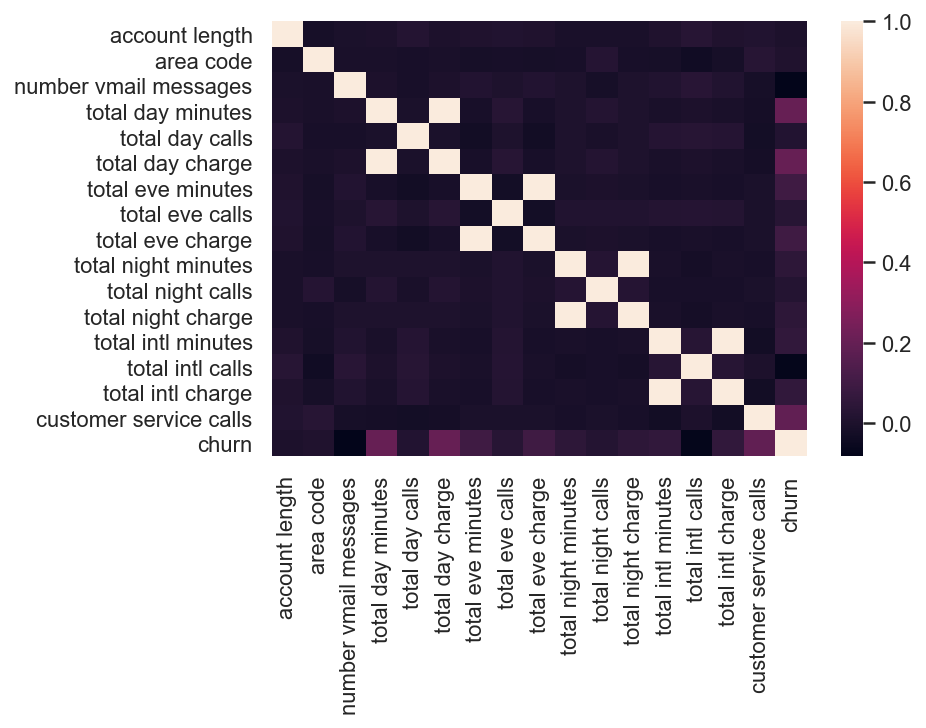

In [18]:
corrmat = df_churn.corr()# COMPLETAR
sns.heatmap(corrmat)

<div class="alert alert-block alert-success" markdown=1>

__Comentarios__. _Correcto_
```python

```
</div>

<font color="#004D7F" size=3> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#004D7F"></i></font> Comentar la gráfica. 

Se puede observar como la gran mayoría de las variables del problema no tienen una elevada correlación entre ellas, llegando como mucho a una correlación de 0.3. Sin embargo, podemos observar como 4 variables tienen una correlación elevada (cerca de 1) con otras variables. Estas relaciones son:

* **total day charge** - **number vmail messages**
* **total eve charge** - **total eve minutes**
* **total night charge** - **total night minutes**
* **total intl charge** - **total intl minutes**

Es normal que estén correlacionadas ya que relacionen el tiempo de una llamada (a distintas horas del día) con el coste de esa llamada, y como es obvio, el tiempo de llamada y el coste son directamente proporcionados. Cuando sube uno, sube el otro y cuando baja uno, baja el otro.

En este caso, se debería eliminar una de las variables que forman la relación, ya que esta variable no nos va a aportar más información del que ya hay disponible al estar correlacionadas entre si. 

Por otro lado, la clase muestra tener alguna correlación con *total day minutes*, *total day charge*, *total eve minutes*, *total eve charge*, *total intl minutes*, *total intl charge* y *customer service calls*, especialmente con este último.

Podemos deducir a priori que **el coste de la llamada y la cantidad de llamadas realizadas al servicio de atención al cliente ** van a tener un **gran impacto** a la hora de detectar  un abandono en el servicio de telefonía. 


<div class="alert alert-block alert-success" markdown=1>

__Comentarios__. _Correcto_
```python

```
</div>

<div style="text-align: left"><font size=4> <i class="fa fa-check-square-o" aria-hidden="true" style="color:#004D7F"></i></font></div>



Llegados a este punto, se dispone de las características de interés en el formato numérico, y se ha decidido tratar algunas como categóricas. Además, se han hecho algunas transformaciones (solamente la clase).

In [20]:
print("Pasos de preprocesamiento: ")
for step, function in enumerate(churn_data_preprocessing):
    print("\t {:d}: {:s}".format(step, function.__name__))

Pasos de preprocesamiento: 
	 0: churn_binarize_class


<div style="text-align: right">
<a href="#inicio"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></font></a>
</div>


---

<a id="section32"></a>
### <font color="#004D7F"> 3.2. Variables Categóricas </font>
<br>

Una vez tratadas las características numéricas se procederá a explorar las categóricas. En este caso, la forma de proceder es distinta, ya que cada una será tratada de forma independiente. En primer lugar se visualizarán todas ellas.

<div class="alert alert-block alert-danger">
    
<i class="fa fa-exclamation-triangle" aria-hidden="true"></i> Se les llama categóricas, pero no tienen por qué corresponder al tipo `Categorical` de _Pandas_. 
</div>

In [21]:
df_churn[cat_df_columns].describe()

,state,phone number,international plan,voice mail plan
count,2408,2408,2408,2408
unique,51,2408,2,2
top,WV,411-4293,no,no
freq,82,1,2175,1745


Puede apreciarse que aparecen tres situaciones distintas, y que se tienen que tratar por separado:

* El teléfono (`phone number`) es realmente un identificador, y no debe ser utilizado.
* Dos de las variables (`international plan` y `voice mail plan`) son binarias. Estas no requieren más procesamiento que el paso a numéricas.
* El estado parece una variable categórica que hay que tratar como tal.  

#### <font color="#004D7F"> Número de teléfono </font>


Se aprecia que hay tantos valores como filas, de lo que se reduce que es un índice. Esta columna puede ser borrada directamente. 

<font color="#004D7F" size=3> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#004D7F"></i></font> Crear una función, denominada `remove_phone_number`, que reciba un _DataFrame_ y borre la columna `phone number`.

In [22]:
def remove_phone_number(df):
    # COMPLETAR
    df = df.drop("phone number", axis=1)
    return df

#Comprueba si la función está bien
display(remove_phone_number(df_churn[cat_df_columns].head(5).copy()))

,state,international plan,voice mail plan
175,ND,yes,no
1330,WI,no,no
2703,GA,no,no
2769,TX,no,yes
1125,NJ,no,no


<div class="alert alert-block alert-success" markdown=1>

__Comentarios__. _Correcto_
```python

```
</div>

<font color="#004D7F" size=3> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#004D7F"></i></font> 
Añadir la función `remove_phone_number` a la lista `churn_data_preprocessing`. Utilizarla para eliminar la columna `df_churn['phone number']`. 



In [23]:
#
# COMPLETAR
#
churn_data_preprocessing.append(remove_phone_number)
df_churn = remove_phone_number(df_churn)

<div class="alert alert-block alert-success" markdown=1>

__Comentarios__. _Correcto_
```python

```
</div>

#### <font color="#004D7F"> Planes </font>

La variable que contiene la información sobre los planes internacional y de correo de voz es binaria, aunque se representa con un _String_. Como puede observarse, no parece que pueda tomar otro valor, por lo que su conversión se tratará también en esta fase. 

<font color="#004D7F" size=3> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#004D7F"></i></font> Crear una función, denominada `churn_binarize_plans`, que reciba un _DataFrame_ y transforme las columnas `international plan` y `voice mail plan` a un entero binario.

In [24]:
def churn_binarize_plans(df):
    #
    # COMPLETAR
    #
    replacement_dict = {
                    "international plan" : {
                        "no" : 0,
                        "yes" : 1},
                    "voice mail plan" : {
                        "no" : 0,
                        "yes" : 1}
                    }
    df = df.replace(replacement_dict)
    
    return df # No hace falta

# Comprueba si la función está bien
display(churn_binarize_plans(df_churn.head(5).copy()))

,state,account length,area code,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
175,ND,136,510,1,0,0,256.8,90,43.66,230.1,104,19.56,143.6,82,6.46,9.1,10,2.46,3,0
1330,WI,153,510,0,0,0,159.5,103,27.12,275.5,90,23.42,176.7,126,7.95,10.1,2,2.73,1,1
2703,GA,90,415,0,0,0,113.2,108,19.24,189.3,63,16.09,271.8,124,12.23,14.1,4,3.81,3,0
2769,TX,98,408,0,1,19,110.5,87,18.79,227.8,97,19.36,243.6,84,10.96,11.0,4,2.97,1,0
1125,NJ,106,415,0,0,0,207.9,91,35.34,172.0,109,14.62,191.8,143,8.63,14.4,7,3.89,4,0


<div class="alert alert-block alert-success" markdown=1>

__Comentarios__. _Correcto_
```python

```
</div>

<font color="#004D7F" size=3> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#004D7F"></i></font> 
Añadir la función `churn_binarize_plans` a la lista `churn_data_preprocessing` y utilizarla para transformar las columnas  `df_churn['international plan']` y `df_churn['voice mail plan']`. Añadir las dos variables a la lista de variables numéricas `num_features`.

In [25]:
# Lo añade
# COMPLETAR
churn_data_preprocessing.append(churn_binarize_plans)
# Lo aplica
# COMPLETAR
df_churn = churn_binarize_plans(df_churn)
# Añade las variables
num_features.append('international plan')
num_features.append('voice mail plan')

<div class="alert alert-block alert-success" markdown=1>

__Comentarios__. _Correcto_
```python

```
</div>

#### <font color="#004D7F"> Estado </font>

La última variable categórica es `state`. En principio, no tenemos por qué saber (si se sabe mejor) qué valores son aceptables para esta variable. No obstante, sí que conviene explorarla para determinar, de cara a la posterior transformación, si incluye algún valor anómalo.


<font color="#004D7F" size=3> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#004D7F"></i></font>  Elaborar una gráfica de tipo `sns.countplot` que muestre la variable `state` de `df_churn`. Utilizar `hue=churn`.

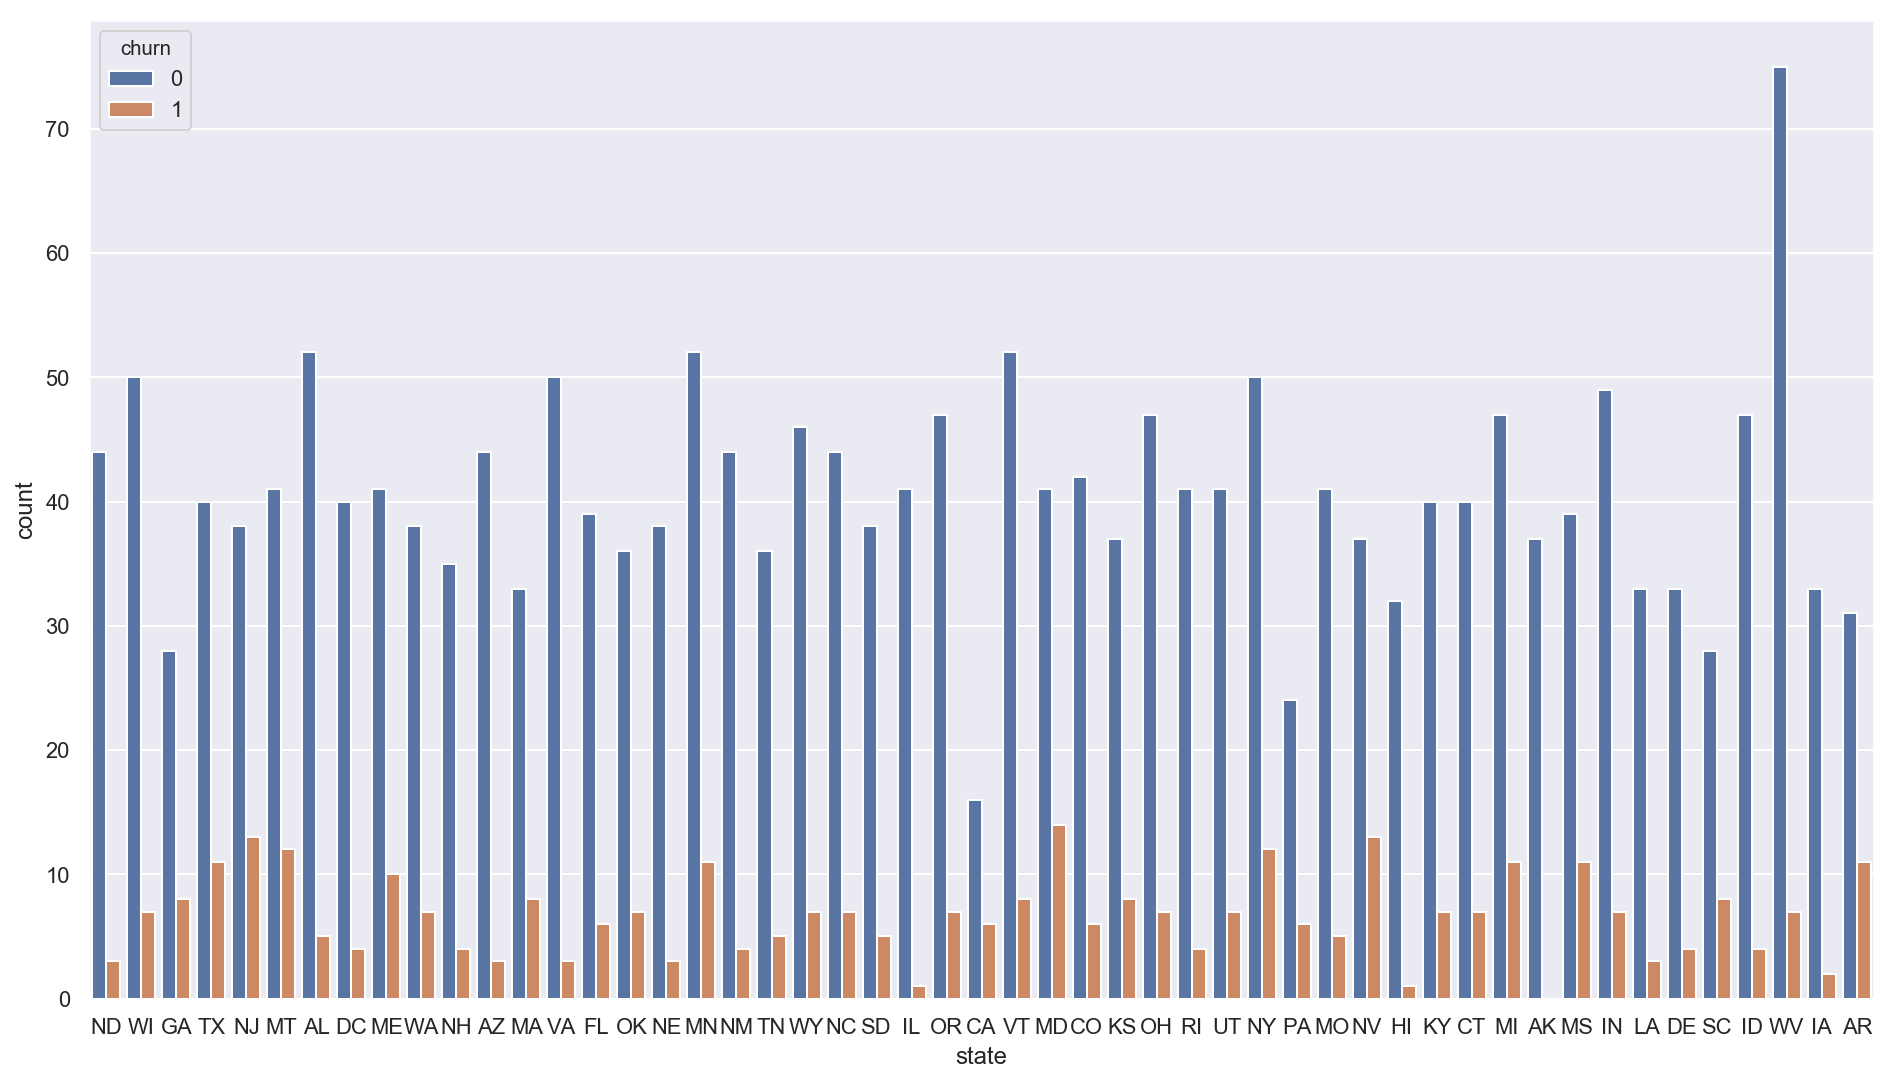

In [26]:
#
# COMPLETAR
#
plt.figure(figsize=(16,9))
sns.countplot("state",hue="churn", data=df_churn)

<div class="alert alert-block alert-success" markdown=1>

__Comentarios__. _Correcto_
```python

```
</div>

<font color="#004D7F" size=3> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#004D7F"></i></font> Comentar, en la siguiente celda, qué se observa en la gráfica. 

Podemos ver como el estado predominante es `WV`, y a priori, en proporción, es donde menos casos de abandono hay. En proporción al número de casos, el estado de `CA` tiene el que mayor número de casos de churn por habitante, además, es el estado menos frecuente del conjunto de datos. El estado donde menos casos de churn hay son los estados de `HI`, `IL`, `AK` y `IA`.

Por lo demás en general, podemos ver como predomina los casos de no churn. Sería interesante hacer un estudio por cada estado, ya que las circunstancias que rodean el abandono del servicio telefónico pueden ser distintas dependiendo del estado en el que viva el cliente.

Si se hubiese balanceado la proporción de casos churn entre el conjunto de entrenamiento y el de test sin tener en cuenta el estado al que pertenecen, obtendríamos una proporción distinta de casos churn en cada estado.

<div class="alert alert-block alert-success" markdown=1>

__Comentarios__. _Correcto_. En realidad de aquí podemos sacar que no hay ningún código de estado anómalo, y además lo otro que has puesto. En estados como Illinois la tasa de abandono es mucho más baja.
</div>

<div style="text-align: left"><font size=4> <i class="fa fa-check-square-o" aria-hidden="true" style="color:#113D68"></i></font></div>


Aunque aparentemente no hay tendencias claras, parece que en principio esta variable podría contener alguna información, por lo que se añade la variable `state` a la lista de variables categóricas `cat_features`. 

In [27]:
cat_features.append('state')

<div style="text-align: right">
<a href="#inicio"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></font></a>
</div>


---

<a id="section33"></a>
### <font color="#004D7F"> 3.3. Preprocesamiento</font>
<br>

Llegados a este punto, se han llevado a cabo las acciones de preprocesamiento necesarias. En el _DataFrame_ resultante quedan variables numéricas, y también dos variables categóricas, que serán tratadas como tal en pasos posteriores.

In [28]:
print("Variables numéricas: ")
print(num_features)
print("\nVariables categóricas")
print(cat_features)

df_churn.head()

Variables numéricas: 
['account length', 'number vmail messages', 'total day minutes', 'total day calls', 'total day charge', 'total eve minutes', 'total eve calls', 'total eve charge', 'total night minutes', 'total night calls', 'total night charge', 'total intl minutes', 'total intl calls', 'total intl charge', 'customer service calls', 'international plan', 'voice mail plan']

Variables categóricas
['area code', 'state']


,state,account length,area code,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
175,ND,136,510,1,0,0,256.8,90,43.66,230.1,104,19.56,143.6,82,6.46,9.1,10,2.46,3,0
1330,WI,153,510,0,0,0,159.5,103,27.12,275.5,90,23.42,176.7,126,7.95,10.1,2,2.73,1,1
2703,GA,90,415,0,0,0,113.2,108,19.24,189.3,63,16.09,271.8,124,12.23,14.1,4,3.81,3,0
2769,TX,98,408,0,1,19,110.5,87,18.79,227.8,97,19.36,243.6,84,10.96,11.0,4,2.97,1,0
1125,NJ,106,415,0,0,0,207.9,91,35.34,172.0,109,14.62,191.8,143,8.63,14.4,7,3.89,4,0


En relación al preprocesamiento, se han aplicado, sucesivamente, las siguientes funciones (__deben aparecer las tres__).

In [29]:
print("\nPasos de preprocesamiento: ")
for step, function in enumerate(churn_data_preprocessing):
    print("\t {:d}: {:s}".format(step, function.__name__))


Pasos de preprocesamiento: 
	 0: churn_binarize_class
	 1: remove_phone_number
	 2: churn_binarize_plans


<font color="#004D7F" size=3> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#004D7F"></i></font> Crear una función, denominada `preprocess_data`, que admita como parámetros un _DataFrame_ y una lista de funciones como la anterior, y las aplique sucesivamente sobre el _DataFrame_.

In [30]:
def preprocess_data(df, churn_data_preprocessing):
    #
    # COMPLETAR
    #
    for func in churn_data_preprocessing:
        df = func(df)
    return df

<div class="alert alert-block alert-success" markdown=1>

__Comentarios__. _Correcto_
```python

```
</div>

La siguiente celda aplica la función `preprocess_data` sobre un _DataFrame_ auxiliar. Como puede observarse, el formato devuelto es similar al de `df_churn` una vez hecho el preprocesamiento.

In [31]:
df_aux = pd.read_csv('data/churn/customerChurnAnalysis.csv').sample(n=5)
preprocess_data(df_aux, churn_data_preprocessing)

,state,account length,area code,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
1944,HI,131,415,0,1,30,174.0,118,29.58,205.3,81,17.45,218.2,90,9.82,6.7,3,1.81,1,0
2407,TX,139,510,1,1,31,203.5,82,34.60,200.3,72,17.03,214.0,112,9.63,13.4,6,3.62,1,1
3112,AR,115,415,0,0,0,139.3,89,23.68,192.3,95,16.35,151.0,75,6.80,9.3,3,2.51,7,1
3104,WI,63,510,0,1,13,214.2,61,36.41,181.2,88,15.40,174.0,68,7.83,10.3,2,2.78,0,0
2436,NM,63,510,0,0,0,207.6,96,35.29,229.0,112,19.47,162.6,131,7.32,13.3,2,3.59,1,0


<div style="text-align: right">
<a href="#inicio"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></font></a>
</div>

---

<a id="section4"></a>
## <font color="#004D7F"> 4. Construcción de un modelo. </font>
<br>

En este punto se ha preparado un _DataFrame_ a partir del cual se puede construir y validar el modelo. Éste conjunto de datos será el punto de partida para la definición de un _Pipeline_ con `scikit-learn`, que también incluye ciertas acciones de preprocesamiento, y es independiente del proceso anterior.  No obstante, sí que será necesario utilizar las listas de características elaboradas anteriormente. 

In [32]:
churn_features = cat_features+num_features

<div style="text-align: right">
<a href="#inicio"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></font></a>
</div>


---

<a id="section41"></a>
### <font color="#004D7F"> 4.1. Creación del Pipeline y construcción de un modelo inicial</font>
<br>

El primer paso en la creación del _Pipeline_ consiste en la transformación de los datos. Uno de los problemas con los que tradicionalmente se ha lidiado en este sentido, es que se han de tratar de manera separada los datos de distintas columnas, que luego han de ser unidas. Desde la versión 0.20, `scikit-learn` proporciona el objeto  [`ColumnTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html#sklearn.compose.ColumnTransformer), que permite tratar por separado las columnas, y facilita enormemente la tarea de transformación.

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i> Podéis leer un par de artículos sobre `ColumnTransformer` en estos enlaces: [post 1](https://medium.com/vickdata/easier-machine-learning-with-the-new-column-transformer-from-scikit-learn-c2268ea9564c) (básico) y [post 2](https://medium.com/dunder-data/from-pandas-to-scikit-learn-a-new-exciting-workflow-e88e2271ef62) (más complejo pero muy interesante).
</div>

<br>

En este contexto, el preprocesamiento para todas las variables de un mismo tipo será similar, por lo que serán sometidas a la misma secuencia de transformaciónes mediante un _Pipeline_. Una vez definido el _Pipeline_ para cada tipo de datos, se aplicarán ambos a las columnas correspondienteds mediante `ColumnTransformer`.

En primer lugar, se va a definir el proceso de transformación para las variables numéricas, que consistirá en:
* Imputación de valores perdidos (`SimpleImputer`) por la mediana. 
* Normalización a media cero y desviación uno (`StandardScaler`).

<font color="#004D7F" size=3> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#004D7F"></i></font> Crear un `Pipeline`, denominado `num_transformer`, que consista en las dos transformaciones descritas anteriormente. 

In [33]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

num_transformer = Pipeline([
    ("preproc_simple_imputer", SimpleImputer(strategy="median")),
    ("preproc_standar_scalar", StandardScaler())
]) # COMPLETAR

<div class="alert alert-block alert-success" markdown=1>

__Comentarios__. _Correcto_
```python

```
</div>

<font color="#004D7F" size=3> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#004D7F"></i></font> Crear otro _Pipeline_, denominado `cat_transformer`, que defina la secuencia de transformaciones para las variables categóricas. Este debe estar formado por un objeto `SimpleImputer` que reemplace los valores perdidos por la etiqueta `missing` (`strategy='constant', fill_value='missing'`), y otro objeto, `OneHotEncoder` que transforme las variables categóricas a etiquetas binarias. Para este último, fijar el parámetro `handle_unknown='ignore'` para que los valores que no se han consierado en el entrenamiento, sean ignorados (codificados a cero).

In [34]:
from sklearn.preprocessing import OneHotEncoder

cat_transformer = Pipeline([
    ("preproc_simple_imputer", SimpleImputer(strategy="constant", fill_value="missing")),
    ("preproc_one_hot_encoder", OneHotEncoder(handle_unknown="ignore"))
])# COMPLETAR

<div class="alert alert-block alert-success" markdown=1>

__Comentarios__. _Correcto_
```python

```
</div>

<font color="#004D7F" size=3> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#004D7F"></i></font> ¿Por qué estos pasos se tienen que incorporar al _Pipeline_?

Estos pasos se incluyen en el *Pipeline* por varios motivos. Primero, para ambas clases de variables, pueden aparecer valores nulos en algunas instancias, por lo que hace falta reemplazarlos por la mediana en el caso de las variables numéricas y por un valor *missing* en el caso de variables categóricas.

En segundo lugar, en el caso de las variables numéricas, también incluimos un `StandardScaler` para normalizar todas las variables numéricas, ya que las variables pueden tener rangos distintos. De esta manera obtenemos un mismo rango de valores para todas las variables.

Por último, para las variables categóricas, también se incluye un `OneHotEncoder` que nos transformarán las variables categóricas en códigos numéricos para ahorrar espacio en memoria. Además, si hay alguna clase desconocida, se ignorará.

Usando *Pipelines* automatizamos los pasos de preprocesamiento para variables nuevas. 

<div class="alert alert-block alert-success" markdown=1>

__Comentarios__. _Correcto_. Otro tema es que scikit-learn no utiliza variables categóricas. 
```python

```
</div>

<div style="text-align: left"><font size=4> <i class="fa fa-check-square-o" aria-hidden="true" style="color:#004D7F"></i></font></div>



<font color="#004D7F" size=3> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#004D7F"></i></font> Crear un objeto de tipo `ColumnTransformer`, denominado `churn_trans`, que aplique las dos secuencias anteriores de transformación sobre las características correspondientes. 

In [35]:
from sklearn.compose import ColumnTransformer
churn_trans = ColumnTransformer(transformers=[
                                                ("cat", cat_transformer, cat_features),
                                                ("num", num_transformer, num_features)
                                ])# COMPLETAR

<div class="alert alert-block alert-success" markdown=1>

__Comentarios__. _Correcto_
```python

```
</div>

Una vez definida la secuencia de preprocesamiento, se definirá un _Pipeline_ inicial para entrenar un modelo (elegido arbitrariamente).

<font color="#004D7F" size=3> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#004D7F"></i></font> Crear un objeto `Pipeline` que aplique la transformación definida en el objeto `churn_trans` anterior, y posteriormente aprenda un modelo de regresión logística. Este modelo (_PipeLine_) se denominará `churn_pipe`.

In [36]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression();

churn_pipe = Pipeline([
                    ("transformer", churn_trans),
                    ("model", lr_model)
])# COMPLETAR

<div class="alert alert-block alert-success" markdown=1>

__Comentarios__. _Correcto_
```python

```
</div>

<font color="#004D7F" size=3> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#004D7F"></i></font>  Entrenar el modelo con los datos preprocesados anteriormente. Imprimir la tasa de acierto.

In [37]:
X = df_churn[churn_features]
y = df_churn['churn']

# COMPLETAR
churn_pipe = churn_pipe.fit(X, y)
print("Tasa de acierto: %.3f" % churn_pipe.score(X, y))

Tasa de acierto: 0.875


<div class="alert alert-block alert-success" markdown=1>

__Comentarios__. _Correcto_
```python

```
</div>

<font color="#004D7F" size=3> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#004D7F"></i></font> ¿Podría considerarse que el resultado es bueno? ¿Por qué?

Depende de las condiciones del problema. En este caso tiene un gran peso el porcentaje de casos positivos acertados. A continuación se muestra el porcentaje de valores negativos total del conjunto de entrenamiento:

In [38]:
print("El porcentaje de muestras negativas es %f" % (sum(df_churn['churn'] == 0) / df_churn.shape[0]))

El porcentaje de muestras negativas es 0.858804


Podemos deducir que el clasificador mostrado es mejor que un clasificador `0R`
 ya que tiene una tasa de acierto de 0.872, pero si no comoprobamos el área bajo la curva (área ROC) no podemos deducir lo bueno o malo que es el clasificador. Lo veremos en el siguiente apartado.

Otro detalle que hemos pasado por alto es que la tasa de acierto se ha calculado sobre el conjunto de datos de entrenamiento y no sobre el de test. Esto hace que los resultados reales puedan ser peores de los reales si se ha sobreajustado. A continuación vamos a comprobar la tasa de acierto con el conjunto de validación.

In [39]:
from sklearn.metrics import accuracy_score
# Preprocessing test dataframe
df_churn_new_proc = preprocess_data(df_churn_new, churn_data_preprocessing)

# Separating attributes and the class variable
X_test = df_churn_new_proc[churn_features]
y_test = df_churn_new_proc["churn"]

#
#y_pred = churn_pipe.predict(X_test)

print("Tasa de acierto (validación): %.3f" % churn_pipe.score(X_test, y_test) )# accuracy_score(y_test, y_pred))

Tasa de acierto (validación): 0.875


Ahora usando el conjunto de validadción observamos como el resultado es muy similar al obtenido con el estimador `0R`, por lo que podemos intuir que la matriz de confusión dará unos resultados malos.

<div class="alert alert-block alert-success" markdown=1>

__Comentarios__. _Correcto_. Aquí no hemos utilizado test porque lo he dejado para después como ejercicio :) Pero muy bien.
```python

```
</div>

<div style="text-align: left"><font size=4> <i class="fa fa-check-square-o" aria-hidden="true" style="color:#004D7F"></i></font></div>


<font color="#004D7F" size=3> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#004D7F"></i></font> Construir la matriz de confusión producida por el modelo anterior con los datos de entrenamiento (puede visualizarse con `sns.heatmap`).

In [40]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


Confusion matrix, without normalization
[[2018   50]
 [ 250   90]]


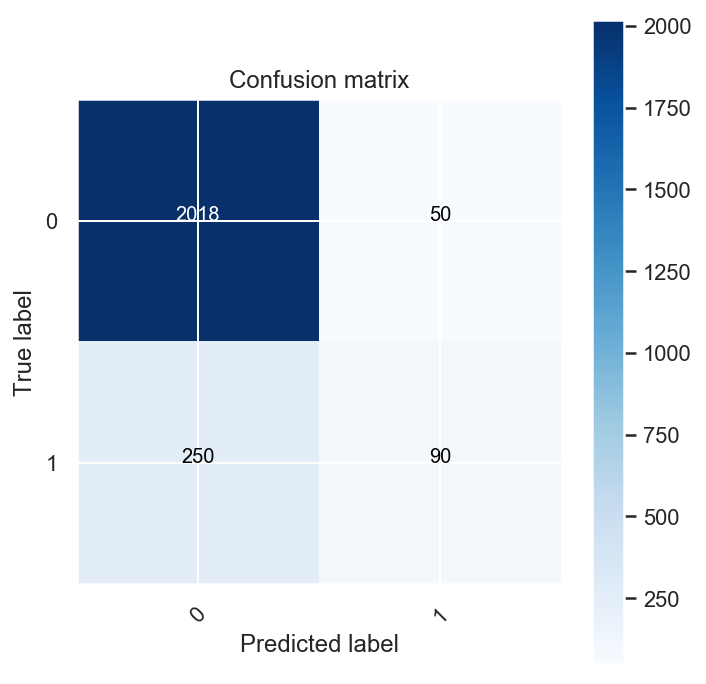

In [41]:
from sklearn.metrics import confusion_matrix
#
# COMPLETAR
#
y_pred = churn_pipe.predict(X)
cm = confusion_matrix(y, y_pred)

plt.figure(figsize=(5,5))
plot_confusion_matrix(cm, classes=[0,1])

<div class="alert alert-block alert-success" markdown=1>

__Comentarios__. _Correcto_. Se puede dibujar la matriz de confusión más fácilmente.
```python
print(c_mat)

sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=True, cmap=plt.cm.Blues)
```
</div>

<font color="#004D7F" size=3> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#004D7F"></i></font> Comentar el resultado.

(Train)

Podemos ver como el número total de instancias positivas es 311, de las cuales el estimador de regresión logística estima 299 como churn negativos y 112 como postivos. 
El porcentaje de valores positivos acertados es 112/311 = **0.36**

Es decir, acierta aproximadamente uno de cada tres churns positivos.

---

<div class="alert alert-block alert-success" markdown=1>

__Comentarios__. _Correcto_ (aunque a mi me salen otros datos, creo que por balancear las posiciones).
```python

```
</div>

Confusion matrix, without normalization
[[355  10]
 [ 43  17]]


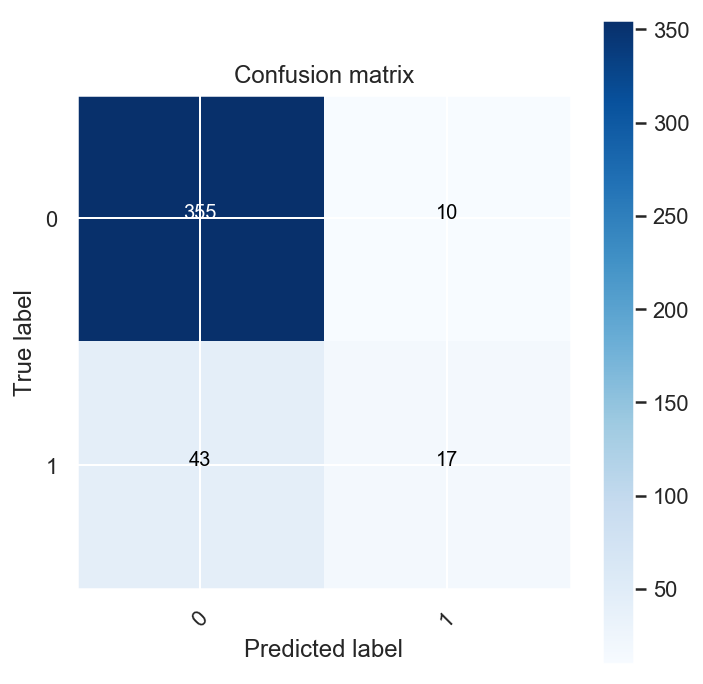

In [44]:
y_pred = churn_pipe.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,5))
plot_confusion_matrix(cm, classes=[0,1])

(Test)

Podemos ver como el número total de instancias positivas es 72, de las cuales el estimador de regresión logística estima 56 como churn negativos y 16 como postivos. 
El porcentaje de valores positivos acertados es 16/72 = **0.22**

Es decir, acierta aproximadamente uno de cada cinco churns positivos.

<div class="alert alert-block alert-success" markdown=1>

__Comentarios__. _Correcto_
```python

```
</div>

<div style="text-align: left"><font size=4> <i class="fa fa-check-square-o" aria-hidden="true" style="color:#004D7F"></i></font></div>

<font color="#004D7F" size=3> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#004D7F"></i></font> Implementar una función, denominada `show_results`, que: reciba dos vectores de igual tamaño, denominados `y` e `y_pred`, con las salidas reales y predicciones del modelo respectivamente; e imprima por pantalla las métricas de interés. Utilizarla para mostrar los resultados (entrenamiento) del modelo anterior.

In [45]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def show_results(y, y_pred):
    #
    # COMPLETAR
    #
    print(f"Accuracy Score: {accuracy_score(y, y_pred)}")
    print(f"Precision Score: {precision_score(y, y_pred)}")
    print(f"Recall Score: {recall_score(y, y_pred)}")
    print(f"F1 Score: {f1_score(y, y_pred)}")

y_pred = churn_pipe.predict(X)
print("(Train)")
show_results(y, y_pred)
print("-------------------------------------------\n")
print("(Test)")
y_pred = churn_pipe.predict(X_test)
show_results(y_test, y_pred)

(Train)
Accuracy Score: 0.8754152823920266
Precision Score: 0.6428571428571429
Recall Score: 0.2647058823529412
F1 Score: 0.37499999999999994
-------------------------------------------

(Test)
Accuracy Score: 0.8752941176470588
Precision Score: 0.6296296296296297
Recall Score: 0.2833333333333333
F1 Score: 0.3908045977011494


<div class="alert alert-block alert-success" markdown=1>

__Comentarios__. _Correcto_
```python

```
</div>

<font color="#004D7F" size=3> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#004D7F"></i></font> ¿Qué métrica resulta de más interés? ¿Depende de algo? ¿Por qué?

Para saber cuál de estas puntuaciones es más importantes, primero hay que saber que definen cada uno.

* $\text{Accuracy Score} = \frac{TP + TN}{P + N}$
* $\text{Precision Score} = \frac{TP}{TP + FP}$
* $\text{Recall Score} = \frac{TP}{TP + FN} = \frac{TP}{P}$
* $\text{F1 Score} = \frac{2\cdot \text{precision}\cdot\text{recall}}{\text{precision} +\text{recall}}$

Donde:
* TP es el número de casos clasificados como positivos y que realmente son positivos.
* TN es el número de casos clasificados como negativos y que realmente son negativos.
* FP es el número de casos que han sido clasificados como positivos pero realmente son negativo.
* FN es el número de casos que han sido clasificados como negativos pero realmente son positivos.
* P es el número total de casos potivos.
* N es el número total de casos negativos.

**¿Qué métrica resulta de más interes?**

En nuestro problema, como lo que realmente interesa es detectar los casos positivos, nos va a interesar siempre más un clasificador que clasifique siempre bien los casos positivos. Por lo tanto, el **recall score** es la puntuación que más nos va a interesar, ya que nos da la tasa de verdaderos positivos acertados.

**¿Depende de algo? ¿Por qué?**

Siempre va a depender del problema planteado porque en cada problema de clasificación supervisado las clases pueden tener distintos pesos de importancia. En algunos casos, igual tienen la misma importancia, por lo que nos interesará el accuracy score.

<div class="alert alert-block alert-success" markdown=1>

__Comentarios__. Muy bien enfocado. Lo único que nos interesa el _recall_... siempre que compense la pérdida de _precision_. Si no, clasificaríamos todos como positivos
```python

```
</div>

<div style="text-align: left"><font size=4> <i class="fa fa-check-square-o" aria-hidden="true" style="color:#004D7F"></i></font></div>

---

<div style="text-align: right">
<a href="#inicio"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></font></a>
</div>


<a id="section42"></a>
### <font color="#004D7F"> 4.2. Selección y ajuste del modelo</font>
<br>

En el apartado anterior, se ha utilizado un modelo cualquiera para ilustrar cómo se debe hacer la construcción y validación de un modelo, además de hacer una primera aproximación a las métricas de interés. En realidad, una vez los datos están disponibles, es necesario seleccionar el modelo y configuración de parámetros que mejor resultados ofrezcan. Para eso, que hay que contemplar varias alternativas, y hacer una selección de modelos para evaluar cada una de ellas.
<br>

En este apartado _se partirá de los datos preprocesados_ para estudiar el modelo de manera aislada. Posteriormente, el modelo seleccionado será usado, junto con el transformador `churn_trans`, para construir el _Pipeline_ definitivo.
<br>

En la siguiente celda se preprocesan los datos almacenados en `X` (el _DataFrame_ original) y se dividen en los conjuntos de entrenamiento y test que serán utilizados en la selección del modelo.

<div class="alert alert-block alert-warning">
    
<i class="fa fa-exclamation-circle" aria-hidden="true"></i> 
Otra sutileza consiste en que puede ser conveniente mirar los outliers antes de los valores perdidos. En caso de que los outliers se conviertan en valores perdidos, posteriormente se tratan como tales. 
</div>

In [ ]:
# from sklearn.model_selection import train_test_split
# random_seed = 0
# X_pre = churn_trans.transform(X) # Preprocesa los datos. 
# X_train, X_test, y_train, y_test = train_test_split(X_pre,
#                                                     y,
#                                                     test_size=0.33,
#                                                     random_state=random_seed,
#                                                     shuffle=True, # Barajamos el conjunto de datos. Añ
#                                                     stratify=y # Repartimos equitativamente las clases
#                                                    )   

In [46]:
## Con Estratificación ##
from sklearn.model_selection import train_test_split
random_seed = 0
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    random_state=random_seed,
                                                    shuffle=True, # Barajamos el conjunto de datos. Añ
                                                    stratify=y # Repartimos equitativamente las clases
                                                   )
X_train = churn_trans.fit_transform(X_train)
X_test = churn_trans.transform(X_test)

Existen una gran cantidad de modelos y parámetros, por lo que hay que definir qué configuraciones se van a crear. En la siguiente celda se almacenan las configuraciones candidatas en el diccionario `cand_models`. Cada entrada almacena un clasificador, y las configuraciones de parámetros que han de ser evaluadas. 

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i> __Nota__: Debido al tamaño del modelo y al coste de las operaciones, es posible utilizar un _Pipeline_ dentro de _GridSearchCV_ (último apartado del ejercicio de Sentiment Analysis). Sin embargo, en este escenario parece más razonable transformar los datos con `churn_trans` solamente una vez.                  
</div>

In [47]:
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

seed = 0
cand_models = { 'SGD': {'clf': SGDClassifier(random_state=seed, max_iter=5),
                        'params': [{'max_iter': [50, 100, 1000], 'tol': [1e-3, 1e-4]}]},
                'Logistic regression': 
                       {'clf': LogisticRegression(random_state=seed),
                        'params': [{'tol': [0.001,0.0001,0.00001], 'C': np.linspace(0.0001,1.0,5)}]},
                'Decision tree': 
                       {'clf': DecisionTreeClassifier(random_state=seed),
                        'params': [{'max_depth': [None, 3, 5, 7]}]},
                'Random forest': 
                        {'clf': RandomForestClassifier(random_state=seed),
                        'params': [{'n_estimators': [10, 20, 50, 100], 'max_depth': [None, 3, 5, 7]}]}
                }

# Muestra los datos correspondientes a una entrada
print("Modelo: ", cand_models['Logistic regression']['clf'])
print("\nParámetros: ", cand_models['Logistic regression']['params'])

Modelo:  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

Parámetros:  [{'tol': [0.001, 0.0001, 1e-05], 'C': array([1.00000e-04, 2.50075e-01, 5.00050e-01, 7.50025e-01, 1.00000e+00])}]


<font color="#004D7F" size=3> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#004D7F"></i></font> Escribir una función, denominada `search_model`, que encuentre la mejor configuración de parámetros para un modelo de clasificación. Esta función toma como parámetros:
* `X`,`y`, que almacenan los datos correspondientes. 
* `model` y `params`, con un modelo de clasificación y sus configuraciones de parámetros, respectivamente. 
* `scoring`, la función que será utilizada para la selección [(funciones de scoring)](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter).

Y ha de devolver, en este orden:
* El modelo de clasificación encontrado,
* su _score_,
* la configuración de parámetros encontrada. 

Esta función debe utilizar internamente un objeto `GridSearchCV`, pero debe devolver el modelo que será utilizado posteriormente (`GridSearchCV.best_estimator_`).

Mostrar también el error de test para cada modelo.

In [48]:
from sklearn.model_selection import GridSearchCV

def search_model(X, y, model, params, scoring=None):
    
    # 
    # COMPLETAR
    #
    gs = GridSearchCV(model, params, scoring=scoring)
    # Training
    gs.fit(X,y)
    
    # The best model, score and params
    best_model = gs.best_estimator_
    best_score = gs.best_score_
    best_params = gs.best_params_
    
    return best_model, best_score, best_params


tested_model = 'Logistic regression'
clf = cand_models[tested_model]['clf']
params = cand_models[tested_model]['params']
scoring = 'accuracy'

model, score, params = search_model(X_train, y_train, clf, params, scoring=scoring)

print(f'Modelo: {model}\n')
print(f'Mejor score ({scoring}): {score:.3f}')

print("\nTest", end=' - ')

# Muestra los resultados de test
# 
# COMPLETAR
#
y_pred = model.predict(X_test)
show_results(y_test, y_pred)

Modelo: LogisticRegression(C=0.250075, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=0,
          solver='warn', tol=0.001, verbose=0, warm_start=False)

Mejor score (accuracy): 0.867

Test - Accuracy Score: 0.8704402515723271
Precision Score: 0.5818181818181818
Recall Score: 0.2857142857142857
F1 Score: 0.3832335329341317


<div class="alert alert-block alert-success" markdown=1>

__Comentarios__. _Correcto_
```python

```
</div>

<font color="#004D7F" size=3> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#004D7F"></i></font> Seleccionar un modelo (manualmente) entre los anteriores, mostrar la matriz de confusión. Para seleccionar el modelo, solamente es necesario cambiar el valor de `tested_model` (hay cuatro posibles).

In [49]:
# 
# COMPLETAR
#
# Defining attributes

# Cojo el mejor modelo de los 4 posibles usando el score recall.
best_clf = None
best_score = 0
best_params = None
scoring = "recall"
for tested_model in cand_models:
    # Getting clf and parameters
    clf = cand_models[tested_model]['clf']
    params = cand_models[tested_model]['params']
    # Running GridSearch
    model, score, params = search_model(X_train, y_train, clf, params, scoring=scoring)
    
    # Getting best estimator
    if score > best_score:
        best_clf = model
        best_params = params
        best_score = score

print(f'Modelo: {best_clf}\n')
print(f'Mejor score ({scoring}): {best_score:.3f}')

print("\nTest", end=' - ')
y_pred = best_clf.predict(X_test)
show_results(y_test, y_pred)

Modelo: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

Mejor score (recall): 0.693

Test - Accuracy Score: 0.9371069182389937
Precision Score: 0.81
Recall Score: 0.7232142857142857
F1 Score: 0.7641509433962265


<div class="alert alert-block alert-success" markdown=1>

__Comentarios__. _Correcto_
```python

```
</div>

<font color="#004D7F" size=3> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#004D7F"></i></font> ¿En base a qué criterio se ha seleccionado ese modelo?

El mejor modelo resulta ser el `DecisionTreeClassifier`, y se ha seleccionado usando la puntuación `recall` ya que de esta forma determinamos lo bien que clasifica los casos positivos.

<div class="alert alert-block alert-success" markdown=1>

__Comentarios__. _Correcto_
```python

```
</div>

<div style="text-align: left"><font size=4> <i class="fa fa-check-square-o" aria-hidden="true" style="color:#004D7F"></i></font></div>

<font color="#004D7F" size=3> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#004D7F"></i></font> Construir el _Pipeline_ final, denominado, `churn_pipe` con el trasnformador `churn_trans` y el modelo escogido (que debe estar almacenado en `model`).

In [50]:
churn_pipe = Pipeline([("preprocess", churn_trans), ("clf", best_clf)])# COMPLETAR

<div class="alert alert-block alert-success" markdown=1>

__Comentarios__. _Correcto_
```python

```
</div>


---

<div style="text-align: right">
<a href="#inicio"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></font></a>
</div>


<a id="section43"></a>
### <font color="#004D7F"> 4.3. Calibración del modelo</font>
<br>

En el modelo de regresión logística, por ejemplo $c_\theta(x)=1$ si $h_\theta(x)>0.5$. Es posible cambiar este umbral (0.5), y con ello se modifican las propiedades del clasificador. Esto es aplicable a todos los modelos que devuelven probabilidad. En este apartado, veremos como afecta este cambio a un árbol de decisión.

<div class="alert alert-block alert-warning">
    
<i class="fa fa-exclamation-circle" aria-hidden="true"></i> Por simplicidad, no incluiremos este proceso en el _Pipeline_.
</div>

In [ ]:
!pip install pydotplus

In [51]:
tested_model = 'Decision tree'
clf = cand_models[tested_model]['clf']
params = cand_models[tested_model]['params']
scoring = 'f1'

tree, tree_score, tree_params = search_model(X_train, y_train, clf, params, scoring=scoring)

In [52]:
print(f'Modelo: {tree}\n')
print(f'Mejor score ({scoring}): {tree_score:.3f}')
print("\nTest - Sin Probabilidades")
y_pred = model.predict(X_test)
show_results(y_test, y_pred)

Modelo: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

Mejor score (f1): 0.735

Test - Sin Probabilidades
Accuracy Score: 0.9245283018867925
Precision Score: 0.9642857142857143
Recall Score: 0.48214285714285715
F1 Score: 0.6428571428571429


In [53]:
print("Test - Usando las probabilidades:")
umbral = 0.5
print("Umbral: ", umbral)
y_pred = tree.predict_proba(X_test)[:,1]>umbral
show_results(y_test, y_pred)

Test - Usando las probabilidades:
Umbral:  0.5
Accuracy Score: 0.9371069182389937
Precision Score: 0.81
Recall Score: 0.7232142857142857
F1 Score: 0.7641509433962265


<font color="#004D7F" size=3> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#004D7F"></i></font> ¿Cómo influye el cambio del umbral en las distintas métricas? ¿Por qué?

Al utilizar el umbral de probabilidades obtenemos una mejor puntuación de todos los scores. Esto es debido a que al usar el árbol de decisión como tal, no se sigue una distribución de probabilidad sino una sucesión de reglas. Esto provoca que en algunas circunstnacias, aunque las probabilidades de que sean de una clase son mayores, se clasifiquen con la otra clase ya que los valores de algunas variables hacen que se tome otra decisión.

Al usar la distribución de probabilidad, no se tiene en cuenta los valores individuales de las variabels, sino a las variables en conjunto. Esto hace que aunque un valor de una variable haga que se tome otra decisión, se puede llegar a ignorar ya que la probabilidad de la instancia indica lo contrario.

En este caso los resultados son mejores porque la distribución de probabilidades de la variable churn siguen distribuciones distintas.

---

<div class="alert alert-block alert-success" markdown=1>

__Comentarios__. Aquí lo que hay que ver es que, al subir la probabilidad (el umbral) baja el `recall` y sube la `precision`. Y al revés. Al bajar el umbral, sube el `recall`, pero baja la `precision`.
```python

```
</div>

Plotting tree


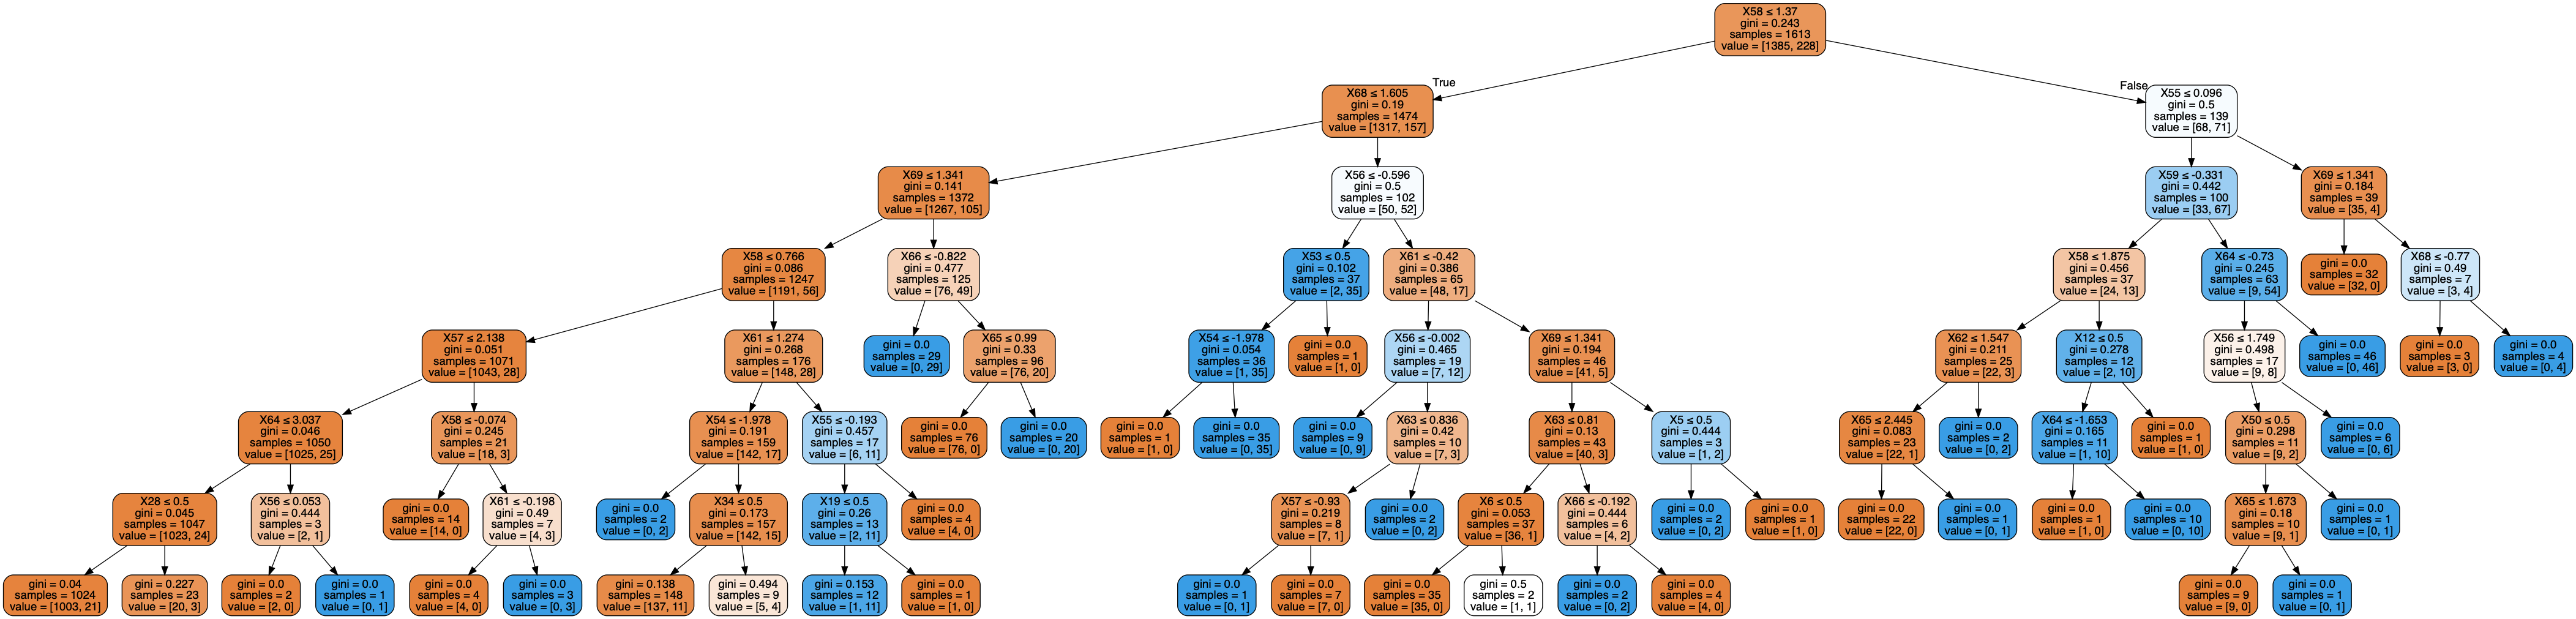

In [54]:
print("Plotting tree")
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(tree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

<div style="text-align: left"><font size=4> <i class="fa fa-check-square-o" aria-hidden="true" style="color:#004D7F"></i></font></div>

<div style="text-align: right">
<a href="#inicio"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></font></a>
</div>

---

<a id="section5"></a>
## <font color="#004D7F"> 5. Validación sobre nuevos datos. </font>
<br>

En este proceso se ha construído el modelo, y se dispone del flujo de trabajo completo, que se compone por una preparación de la base de datos original mediante `preprocess_data`, y del _Pipeline_ `churn_pipe`. Utilizar ambos para predecir los casos de abandono en `df_churn_new`. Reportar el resultado.

In [55]:
#
# COMPLETAR
#
df_churn_new = preprocess_data(df_churn_new, churn_data_preprocessing)
y_pred = churn_pipe.predict(df_churn_new.drop("churn", axis=1))
show_results(df_churn_new["churn"], y_pred)

Accuracy Score: 0.9317647058823529
Precision Score: 0.7719298245614035
Recall Score: 0.7333333333333333
F1 Score: 0.7521367521367521


Podemos ver como da unos resultados similares a los que se obtenían previamente con el conjunto de test, por lo que podemos decir con bastante seguridad que no sobreajusta.

<div class="alert alert-block alert-success" markdown=1>

__Comentarios__. Excelente trabajo Jorge. Excelente. Fíjate que un recall de 0.73 parece un mal resultado... pero ponte en el lugar de la empresa, que es capaz de detectar al 73% de los clientes que see van a ir.
```python

```
</div>

<div style="text-align: right">
<a href="#inicio"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></font></a>
</div>

---

<div style="text-align: right"> <font size=6><i class="fa fa-coffee" aria-hidden="true" style="color:#004D7F"></i> </font></div>